In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment/test.tsv
/kaggle/input/twitter-sentiment/train.tsv


##### <span style="color: red;">If you find this notebook helpful, please leave an UPVOTE to encourage me, it is very helpful!</span>

# Importing Dependencies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.13.0
Keras version: 2.13.1


# Data Preprocessing

We will combine the train and test tsv's temporarily to perform data preprocessing and visualization. It will be splitted again later on.

In [3]:
initial_data = pd.read_csv("/kaggle/input/twitter-sentiment/train.tsv", sep='\t')
initial_test_data = pd.read_csv("/kaggle/input/twitter-sentiment/test.tsv", sep='\t')

data = pd.concat([initial_data, initial_test_data], ignore_index=True)
data.head()

id                                              tweet  \
0  264183816548130816  Gas by my house hit $3.39!!!! I'm going to Cha...   
1  264249301910310912  Iranian general says Israel's Iron Dome can't ...   
2  264105751826538497  with J Davlar 11th. Main rivals are team Polan...   
3  264094586689953794  Talking about ACT's && SAT's, deciding where I...   
4  254941790757601280  They may have a SuperBowl in Dallas, but Dalla...   

   label  
0      1  
1     -1  
2      1  
3     -1  
4     -1

We can see there are 3 classes : postivie, negative and nuetral

In [4]:
data.columns = ['id', 'tweet', 'sentiment']
data.head()

id                                              tweet  \
0  264183816548130816  Gas by my house hit $3.39!!!! I'm going to Cha...   
1  264249301910310912  Iranian general says Israel's Iron Dome can't ...   
2  264105751826538497  with J Davlar 11th. Main rivals are team Polan...   
3  264094586689953794  Talking about ACT's && SAT's, deciding where I...   
4  254941790757601280  They may have a SuperBowl in Dallas, but Dalla...   

   sentiment  
0          1  
1         -1  
2          1  
3         -1  
4         -1

ID is useless

In [5]:
df = data.drop(['id'], axis=1)
# testdata = test.drop(['id'], axis=1)
df.head()

tweet  sentiment
0  Gas by my house hit $3.39!!!! I'm going to Cha...          1
1  Iranian general says Israel's Iron Dome can't ...         -1
2  with J Davlar 11th. Main rivals are team Polan...          1
3  Talking about ACT's && SAT's, deciding where I...         -1
4  They may have a SuperBowl in Dallas, but Dalla...         -1

In [6]:
num_ones = (data['sentiment'] == 1).sum()
num_neg_ones = (data['sentiment'] == -1).sum()
num_zeros = (data['sentiment'] == 0).sum()

print("Number of 1s:", num_ones)
print("Number of 0s:", num_zeros)
print("Number of -1s:", num_neg_ones)

Number of 1s: 3295
Number of 0s: 4282
Number of -1s: 1329


Data is ducking skewed, need to fix that with some sampling techniques

# Visualizing the Data

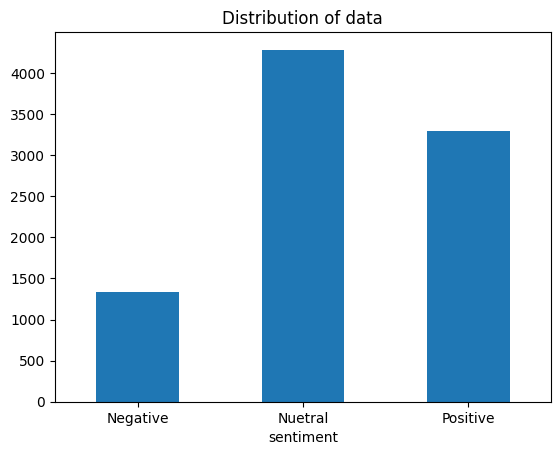

In [8]:
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Nuetral', 'Positive'], rotation=0)

text, sentiment = list(df['tweet']), list(df['sentiment'])

Lets perform some upsampling to balance the data

In [11]:
from sklearn.utils import resample

minority_class = data[data['sentiment'] == -1]

# Upsample the minority class to match the number of samples 
minority_upsampled = resample(minority_class, replace=True, n_samples=1000, random_state=42)

# Combine the majority class with the upsampled minority class
upsampled_data = pd.concat([data, minority_upsampled])
upsampled_data.shape

# print(minority_class)
# print(minority_upsampled)

(9906, 3)

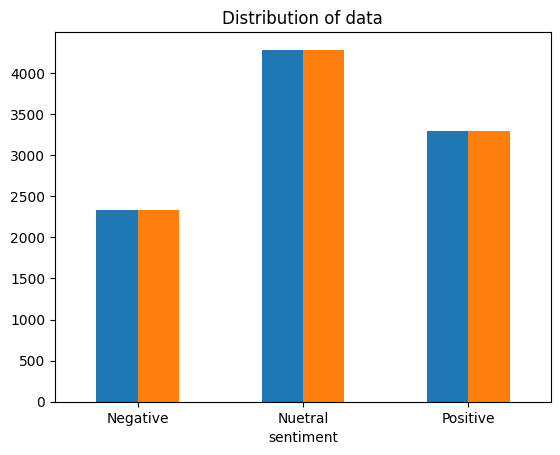

In [12]:
ax = upsampled_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Nuetral', 'Positive'], rotation=0)

text, sentiment = list(upsampled_data['tweet']), list(upsampled_data['sentiment'])

In [13]:
num_ones = (upsampled_data['sentiment'] == 1).sum()
num_neg_ones = (upsampled_data['sentiment'] == -1).sum()
num_zeros = (upsampled_data['sentiment'] == 0).sum()

print("Number of 1s:", num_ones)
print("Number of 0s:", num_zeros)
print("Number of -1s:", num_neg_ones)

Number of 1s: 3295
Number of 0s: 4282
Number of -1s: 2329


In [14]:
df = upsampled_data.copy()
df.shape

(9906, 3)

Now the data seems more balanced.

# Text Preprocessing

In [15]:
df.head()

id                                              tweet  \
0  264183816548130816  Gas by my house hit $3.39!!!! I'm going to Cha...   
1  264249301910310912  Iranian general says Israel's Iron Dome can't ...   
2  264105751826538497  with J Davlar 11th. Main rivals are team Polan...   
3  264094586689953794  Talking about ACT's && SAT's, deciding where I...   
4  254941790757601280  They may have a SuperBowl in Dallas, but Dalla...   

   sentiment  
0          1  
1         -1  
2          1  
3         -1  
4         -1

data dirty. Must clean dirty (apply wall-e meme)

In [16]:
# This line imports a list of common English stopwords using the Natural Language Toolkit (NLTK) library.
# Stopwords are words that are commonly used in the English language and are often removed from text data
# because they don't usually provide meaningful information for text analysis. Examples of stopwords 
# include "the," "and," "is," "in," etc.

stop_words = stopwords.words('english')

# This line initializes a stemming algorithm called the Snowball Stemmer for the English language using
# the NLTK library. Stemming is the process of reducing words to their root or base form. For example, 
# it transforms "running" to "run" and "jumps" to "jump."
stemmer = SnowballStemmer('english')

# This line defines a regular expression (regex) pattern used for text cleaning.
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [17]:
df.head()

id                                              tweet  \
0  264183816548130816  Gas by my house hit $3.39!!!! I'm going to Cha...   
1  264249301910310912  Iranian general says Israel's Iron Dome can't ...   
2  264105751826538497  with J Davlar 11th. Main rivals are team Polan...   
3  264094586689953794  Talking about ACT's && SAT's, deciding where I...   
4  254941790757601280  They may have a SuperBowl in Dallas, but Dalla...   

   sentiment  
0          1  
1         -1  
2          1  
3         -1  
4         -1

In [18]:
import re

def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
            
    return " ".join(tokens)

In [19]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))
df.head()

id                                              tweet  \
0  264183816548130816           gas house hit 3 39 going chapel hill sat   
1  264249301910310912  iranian general says israel iron dome deal mis...   
2  264105751826538497  j davlar 11th main rivals team poland hopefull...   
3  264094586689953794  talking act sat deciding want go college apply...   
4  254941790757601280  may superbowl dallas dallas winning superbowl ...   

   sentiment  
0          1  
1         -1  
2          1  
3         -1  
4         -1

### Lets view some positive words

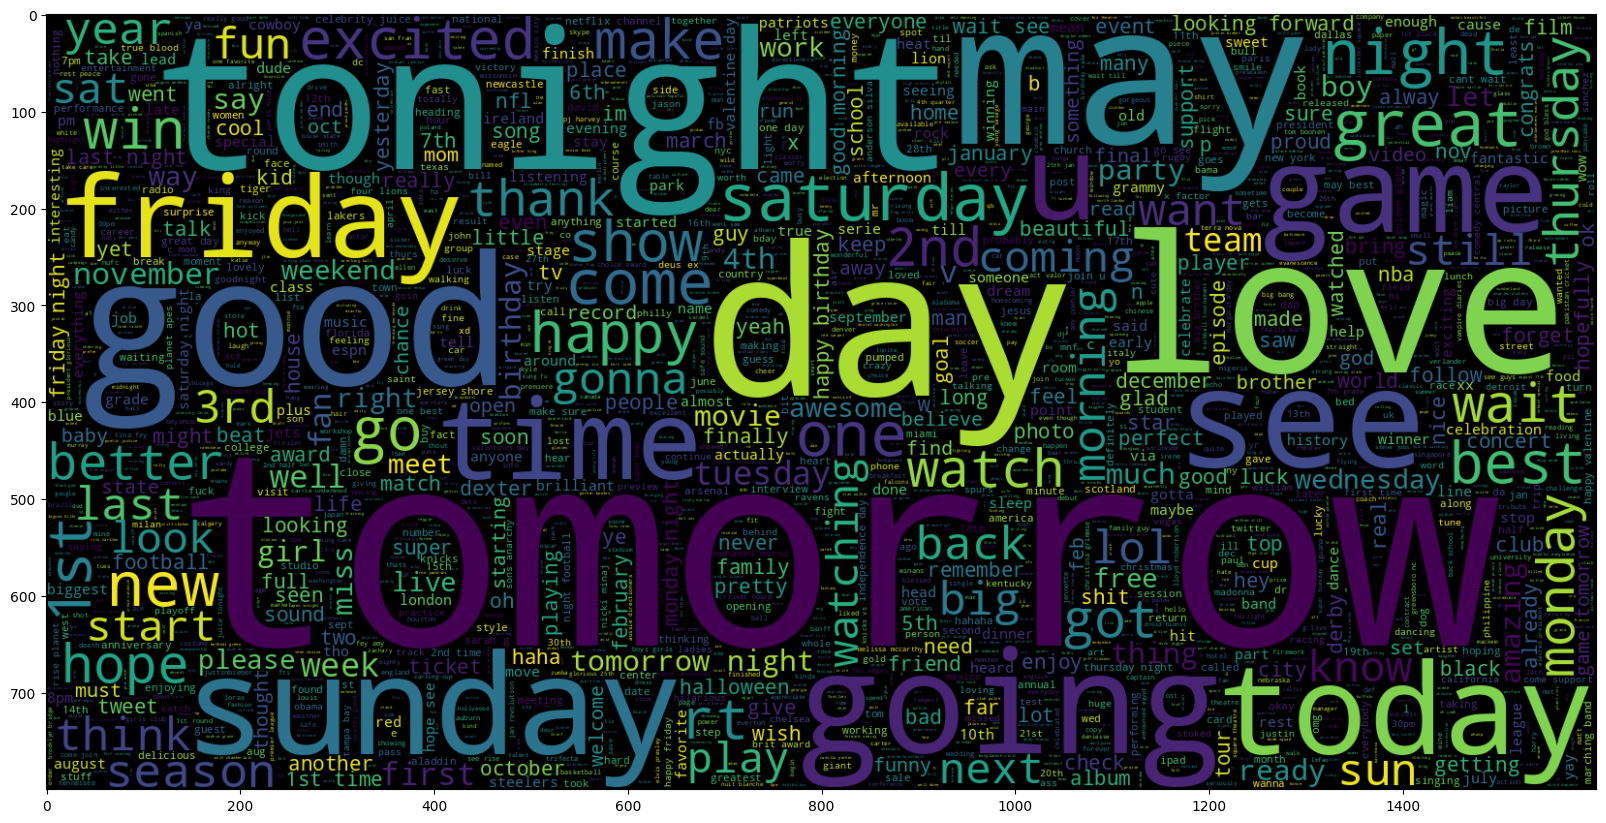

In [20]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

### And some neutral

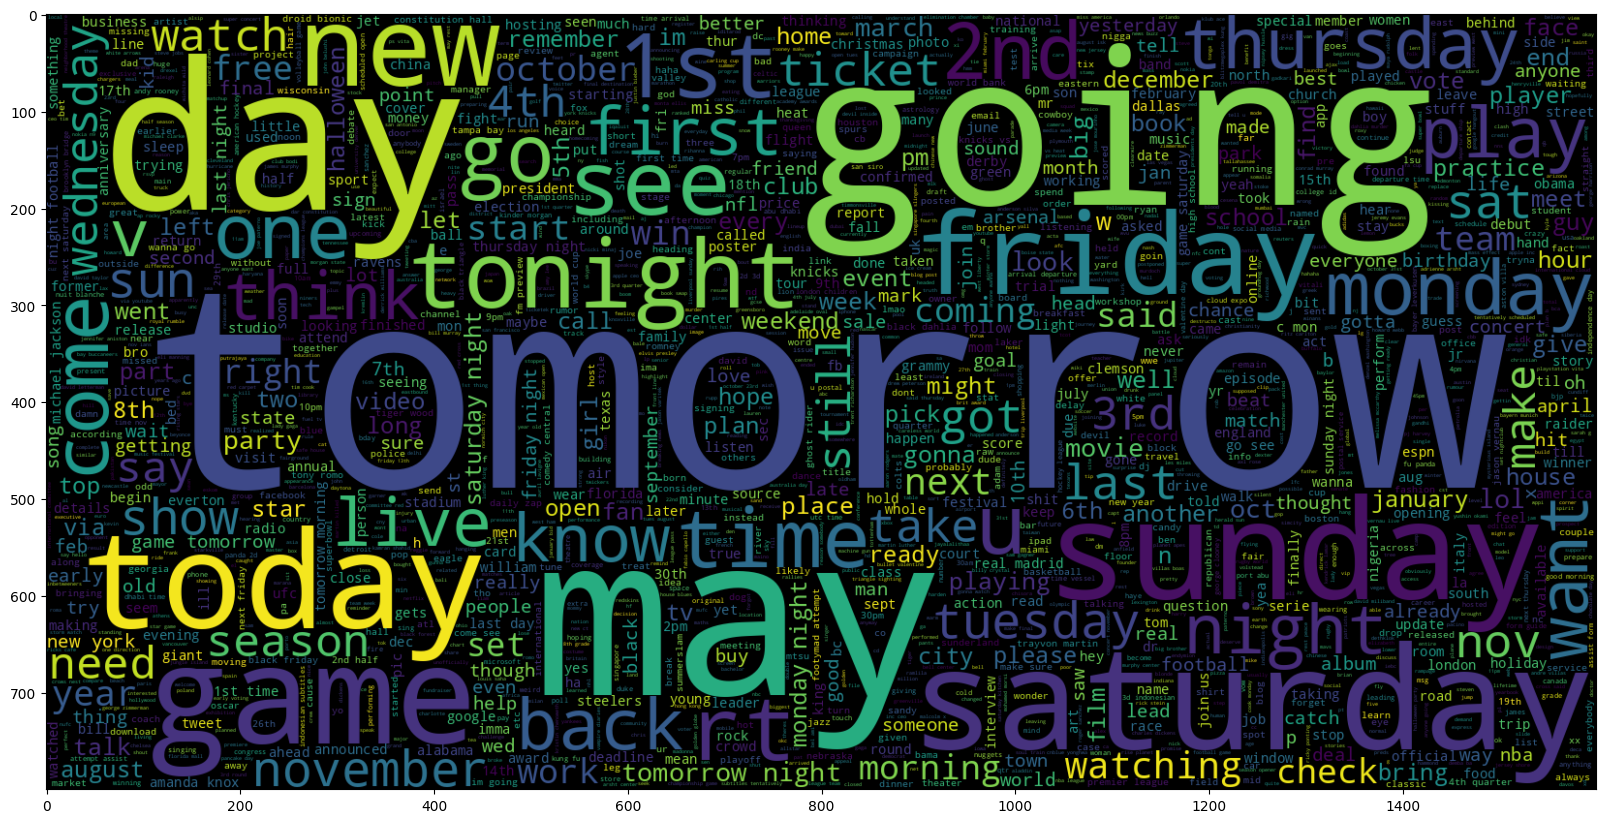

In [22]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear')

### Annnnd some negative

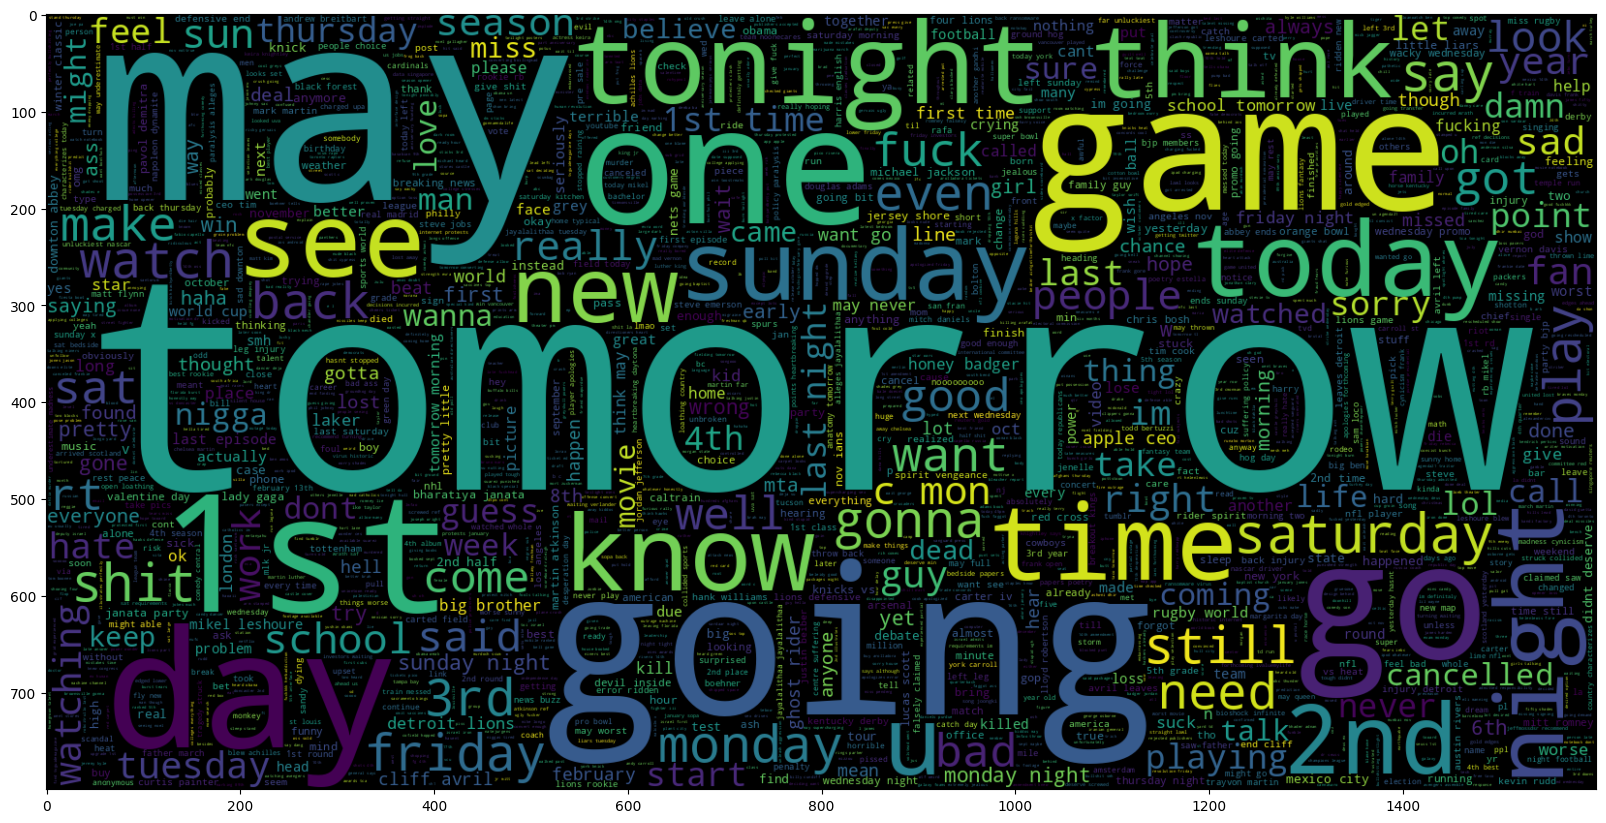

In [21]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == -1].tweet))
plt.imshow(wc , interpolation = 'bilinear')

# Train and Validation Split

Here ill just be referring the to validation data as test data temporarily

In [23]:
TRAIN_SIZE = 0.9
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [24]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=100)

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 8915
Test Data size 991


# Tokenization
breaks sentences down into tokens

In [25]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 17526


In [26]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (8915, 30)
Testing X Shape: (991, 30)


In [27]:
labels = train_data.sentiment.unique().tolist()

# Label Encoding 
(is it needed tho idts)

In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8915,)
y_test shape: (991,)


thats no good format

In [29]:
from tensorflow.keras.utils import to_categorical

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# for lstm, since it requires catgorical data
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8915, 3)
y_test shape: (991, 3)


# Word Embedding
tbh i forgor what this really is

also transfer learning pog

In [34]:
# found the dont download code edit remaining

!wget http://nlp.stanford.edu/data/glove.6B.zip 
!unzip glove.6B.zip

--2023-11-15 03:18:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-15 03:18:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-15 03:18:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [70]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
# BATCH_SIZE = 1024
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [36]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:  
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [37]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [38]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Training the Model - LSTM

In [71]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [72]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = tf.keras.Model(sequence_input, outputs)

In [73]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           5257800   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 30, 300)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            96064     
                                                                 
 dropout_5 (Dropout)         (None, 26, 64)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               197632    
 onal)                                                     

In [74]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [75]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(8915, 30)
(8915, 3)
(991, 30)
(991, 3)


In [76]:
# history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test))

Epoch 1/20
279/279 [==============================] - 62s 198ms/step - loss: 0.9757 - accuracy: 0.5162 - val_loss: 0.9123 - val_accuracy: 0.5651
Epoch 2/20
279/279 [==============================] - 55s 196ms/step - loss: 0.8702 - accuracy: 0.6003 - val_loss: 0.8323 - val_accuracy: 0.6387
Epoch 3/20
279/279 [==============================] - 55s 196ms/step - loss: 0.8179 - accuracy: 0.6350 - val_loss: 0.8258 - val_accuracy: 0.6468
Epoch 4/20
279/279 [==============================] - 54s 195ms/step - loss: 0.7783 - accuracy: 0.6603 - val_loss: 0.8132 - val_accuracy: 0.6307
Epoch 5/20
279/279 [==============================] - 54s 195ms/step - loss: 0.7333 - accuracy: 0.6854 - val_loss: 0.7675 - val_accuracy: 0.6761
Epoch 6/20
279/279 [==============================] - 54s 194ms/step - loss: 0.7065 - accuracy: 0.6943 - val_loss: 0.7589 - val_accuracy: 0.6842
Epoch 7/20
279/279 [==============================] - 54s 194ms/step - loss: 0.6867 - accuracy: 0.7019 - val_loss: 0.7469 - val_ac

alright to the training accuracy is good, but the testing accuracy isnt, which suggests that the model is overfitting.

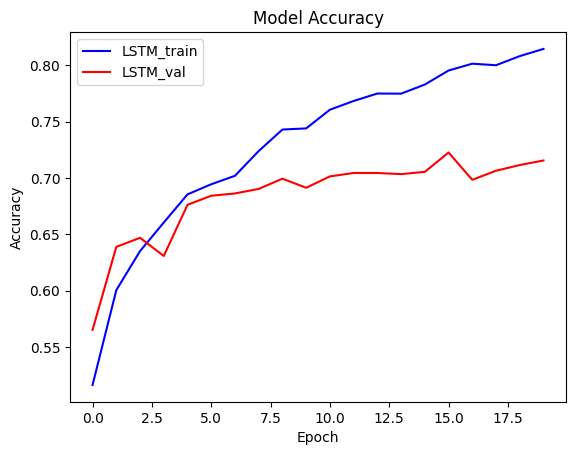

In [79]:
plt.plot(history.history['accuracy'], c='b', label='LSTM_train')
plt.plot(history.history['val_accuracy'], c='r', label='LSTM_val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Saving the Model for Deployment Purpose

In [ ]:
from tensorflow.keras.models import save_model

# Save the TensorFlow model in .h5 format
save_model(model, 'sentiment_analysis_model1.h5')

In [80]:
def decode_sentiment(score):
    a, b, c = score
    
    if (a >= b and a >= c):
        return "negative"
    elif (b >= a and b >= c):
        return "neutral"
    else:
        return "positive"

In [90]:
def make_prediction(text):

    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0]
    label = decode_sentiment(score)

    return str(label)

In [92]:
make_prediction("I love you")

1/1 [==============================] - 0s 32ms/step


'positive'

In [93]:
make_prediction("I hate you")

1/1 [==============================] - 0s 31ms/step


'negative'

In [94]:
make_prediction("let meet next week")

1/1 [==============================] - 0s 31ms/step


'neutral'

Considering even humans have difficulty to interpret whether a message is positive or not (especially us single peeps), having 7 out of 10 responses correctly classified is decent. I hope to improve more on this in the future. Thank you!

##### <span style="color: red;">If you find this notebook helpful, please leave an UPVOTE to encourage me, it is very helpful!</span>